In [27]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import sys
sys.path.append('/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code')
import modules as mod

Simulate multiband light curve of a binary supermassive black hole, using the real quasar colors from SDSS. I pick one quasar, and simulating the light curve in one band, I add offsets to simulate simultaneous (SDSS-like) multi-band observations.  Initially,  the cadence is random,  over 1000 days, which is  10 times the input timescale, as well as 10 times the input period, with the amplitude of DRW variability ($SF_{\infty}$) equal to the amplitude of sinusoidal variability.  I start with modelling in magnitude space  - later to implement first simulating the DRW and sinusoidal components in flux space, and converting to magnitudes. 

I first test how the multiband LS works here -  and it works just fine. I test for spurious frequency peaks from  pg.39 of "Understanding Lomb Scargle Periodogram"  (harmonic frequencies, windowing function aliases ). It's not an issue initially because the data is very densely sampled with random sampling times, so there is not much regularity to windowing.   

I take a light curve with  real SDSS cadence (RR Lyr from Sesar2010), to show that indeed for a ground-based survey, there are definitely frequency peaks due to aliasing (windowing), which have to be accounted for.  In this case, the searched frequency range is so narrow that we do find the true period. 

Finally, I take the multiband simulated DRW+sinusoid light curve prepared initially,  and show that because it is so well sampled, we easily recover the input period at 100 days.  However, if I downsample taking randomly only 1 in 20 points ( from 1000 per band,  i.e. $\Delta t \approx 1$ day, to 50 per band, i.e. $\Delta t \approx 20 $ days), we can't recover  the input period anymore with single band periodogram, but we do with multiband periodogram. 

This is very encouraging because it means that if we combine light curves from SDSS, CRTS, PS1, PTF, etc.,  ending up in multi-band non-simultaneous light curve, we should be able to find the periodicity using the MultiBand Lomb Scargle, that with a single band (even requiring peaks to be in the same place), we would simply miss.


Now I'd need to check the feasibility of multiband as a function of 

* $SF_{\infty} $ / A 
* $\tau  $ / P 
* $\tau $ / baseline 
* cadence : 
  * how the light curve is sampled  - random point across the space,  or SDSS-like + PS1 + PTF + CRTS cadences ? 
  * how densely it is sampled :  number of points 


Grab the QSO colors from the SDSS DB9 to simulate the multiband DRW 

In [2]:
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)

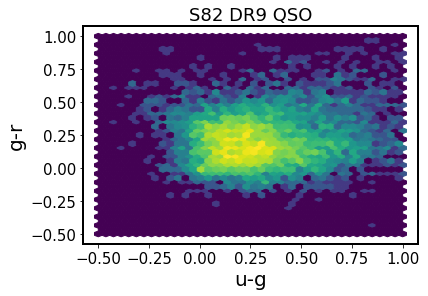

In [17]:
%matplotlib inline
plt.hexbin(SDSS_DB_QSO['u']-SDSS_DB_QSO['g'],
            SDSS_DB_QSO['g']-SDSS_DB_QSO['r'],
          extent=(-0.5,1,-0.5,1),
          gridsize=40,
          bins=  'log')
plt.title('S82 DR9 QSO')
plt.xlabel('u-g')
plt.ylabel('g-r')

Pick the center : u-g = 0.25 , g-r = 0.25 ...  What are the other colors for that quasar ? 



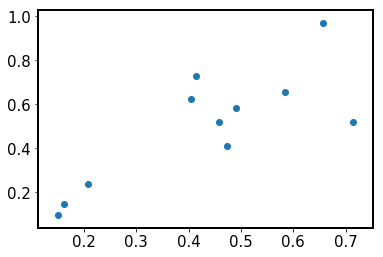

In [21]:
ug = SDSS_DB_QSO['u']-SDSS_DB_QSO['g']
gr = SDSS_DB_QSO['g']-SDSS_DB_QSO['r']

m = (0.24 < ug) * (ug < 0.26) * (0.24 < gr) * (gr < 0.26) * 
gi_sel = SDSS_DB_QSO[m]['g'] - SDSS_DB_QSO[m]['i'] 
gz_sel = SDSS_DB_QSO[m]['g'] - SDSS_DB_QSO[m]['z'] 
plt.scatter(gi_sel, gz_sel)

In [22]:
sdss = SDSS_DB_QSO.copy()

In [23]:
sdss['ug'] = sdss['u'] - sdss['g']
sdss['gr'] = sdss['g'] - sdss['r']
sdss['gi'] = sdss['g'] - sdss['i']
sdss['gz'] = sdss['g'] - sdss['z']

sdss[m]

dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,ug,gr,gi,gz
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
83252,2.194558,0.290413,304,-26.037,-26.232,1.6863,9.082,46.481,19.862,19.62,19.377,19.036,18.966,0.264,0.242,0.243,0.584,0.654
277125,350.606934,-0.465577,76062,-26.266,-26.51,1.5154,9.258,46.518,19.261,19.01,18.753,18.537,18.599,0.216,0.251,0.257,0.473,0.411
608163,16.612875,-1.228701,2542,-25.546,-26.026,1.7689,9.472,46.32,20.523,20.266,20.022,19.775,19.682,0.602,0.257,0.244,0.491,0.584
689841,19.891775,0.109772,2999,-23.87,-24.527,1.1133,8.435,45.715,20.582,20.336,20.088,20.186,20.239,0.183,0.246,0.248,0.15,0.097
731856,342.323059,-0.673256,75108,-25.429,-26.013,2.0554,0.0,0.0,20.851,20.606,20.351,20.192,19.878,0.488,0.245,0.255,0.414,0.728
788848,341.690643,0.608181,75033,-26.821,-27.319,0.972,9.227,46.907,17.476,17.216,16.962,17.009,16.98,0.431,0.26,0.254,0.207,0.236
1585757,33.484455,0.019203,5187,-24.694,-25.151,1.3891,8.354,46.043,20.592,20.346,20.101,19.887,19.826,0.174,0.246,0.245,0.459,0.52
2005043,39.402977,-1.116566,6042,-24.059,-24.547,1.0433,8.354,45.873,20.245,19.995,19.744,19.833,19.849,0.162,0.25,0.251,0.162,0.146
3768784,52.668907,-0.218766,7939,-24.409,-25.202,1.4681,8.737,45.877,21.102,20.846,20.604,20.442,20.224,0.518,0.256,0.242,0.404,0.622


Simulate g band,  and apply offsets to get all other bands : 
    
    

True A= 0.2  true omega= 0.06283185307179587
Finished


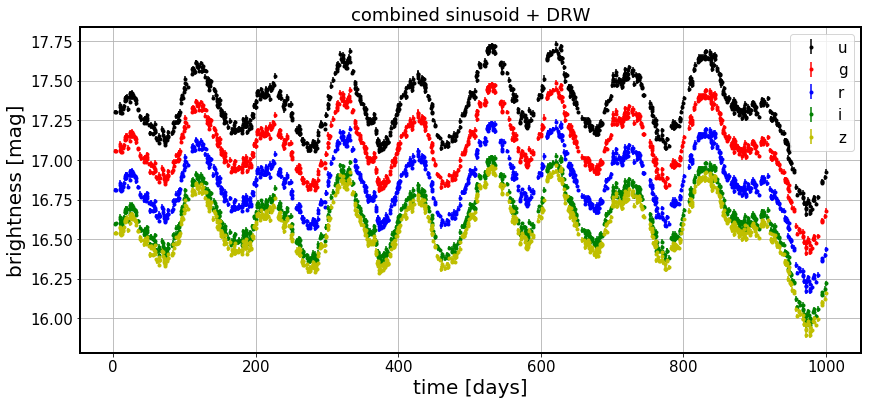

In [82]:
%matplotlib inline

# DRW params 
tau_in = 100 # days 
# sigma_in = 0.2 # mag 
SF_inf = 0.2 # sigma_in * np.sqrt(2) 

# sinusoid params, 
# expressed in terms of DRW input timescale
# and the DRW asymptotic value of SF at large 
# dt 
#fP_values = [0.01,0.1,1,10,100]
#fA_values = [0.001,0.01,0.1,0.25,0.5,0.75,1] 

i =  0 
fP, fA = 1, 1 
#for fP, fA in product(fP_values, fA_values) : 
period=  fP * tau_in
omega = 2*np.pi / period
A  = fA * SF_inf

# the time space : ten times the input DRW timescale 
np.random.seed(41)  # The input coordinates must be sorted
t = np.sort(np.random.uniform(0, 10*tau_in, 1000))  

# the photometric errors drawn from uniform distribution
# between lower and upper noise value 
yerr = np.random.uniform(0.01, 0.02, len(t))
noise = yerr * np.random.randn(len(t)) 

# simulate DRW with Gaussian noise 
y_DRW = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 0) 

print('True A=', A, ' true omega=', omega)

# add Gaussian noise to the pure sinusoid 
y_sin =  A*np.sin(omega*t) 

dic = {'time':t, 'sinusoid':y_sin, 'DRW':y_DRW, 
       'noise':noise, 
       'err':yerr,'tau':tau_in, 'sigma':sigma_in,
       'fP':fP, 'fA':fA
      }
# we also save the time series here 
np.save('DRW_sin_time_series_'+str(i).zfill(2), dic)


# plot the combined time series on a separate panel 
y_g = y_sin+y_DRW+noise+17

# apply offsets ...
y_r = y_g - 0.245
y_u = y_g + 0.246
y_i = y_g - 0.459
y_z = y_g - 0.52 

fig,ax = plt.subplots(1,1,figsize=(14,6))
ax.errorbar(t, y_u, yerr, fmt=".k", capsize=0, label='u')
ax.errorbar(t, y_g, yerr, fmt=".r", capsize=0, label='g')
ax.errorbar(t, y_r, yerr, fmt=".b", capsize=0, label='r')
ax.errorbar(t, y_i, yerr, fmt=".g", capsize=0, label='i')
ax.errorbar(t, y_z, yerr, fmt=".y", capsize=0, label='z')
ax.legend(fontsize=15)
ax.set_xlabel("time [days]")
ax.set_ylabel("brightness [mag]")
ax.set_title('combined sinusoid + DRW')
ax.grid()
#plt.savefig('DRW_sin_comparison_'+str(i).zfill(2)+'.png')
#plt.close(fig)
i += 1 
print('Finished')

### Do MultiBand LS on that light curve ,  check the effect of windowing ... 

In [96]:
# stack all times, errors, mags together,
# in a format digestible by gatspy LS Multiband 
time = np.tile(t,5)
dy = np.tile(yerr,5)
filts = np.tile(['u'], len(t))
for f in 'griz' : 
    filts = np.append(filts, np.tile([f], len(t)))
    
mags = y_u
mags = np.append(mags, y_g)
mags = np.append(mags, y_r)
mags = np.append(mags, y_i)
mags = np.append(mags, y_z)



Here the DRW params are : $\tau=100$ days,  $SF_{\infty} = 0.2$ mag, and sinusoidal params are: $A=SF_{\infty}$, $P = \tau$ ,  

This illustrated the offsets ... Let's try fitting that with the multiband LS (https://github.com/jakevdp/multiband_LS/ )

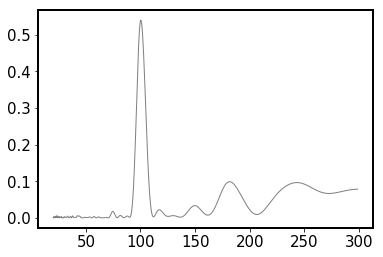

In [125]:
from gatspy.periodic import  LombScargleMultiband

Nbase  = 1; Nband = 0 
LS_multi = LombScargleMultiband(Nterms_base=Nbase, Nterms_band=Nband)
LS_multi.fit(time, mags, dy, filts)

# manually set the period grid ... 
# span between arbitrarily chosen
# 20 and the  1/3 of the span of data .. 
#periods = np.linspace(20,max(time) - min(time), 1000)
periods = np.logspace(np.log10(20),np.log10(0.3 * (max(time) - min(time))), 1000)


# choose grid regular in frequency ...
pmin = 20
pmax = 0.3 * (max(time) - min(time))
#fmin = 1 / pmax
#fmax  = 1/ pmin
#frequencies = 
P_multi = LS_multi.periodogram(periods)
#periods, P_multi = LS_multi.periodogram_auto()
plt.plot(periods, P_multi , lw=1, color='gray')

best_period = periods[np.argmax(P_multi)]

# check the f_peak / m for m = 2,3 


f_peak = 1 / best_period 
freqs  = 1 / periods 

0.0005457689746909557

Peak power is  0.539296933043
power at f_peak /  2 = 0.07846541003039588
power at f_peak /  3 = 0.0005457689746909557


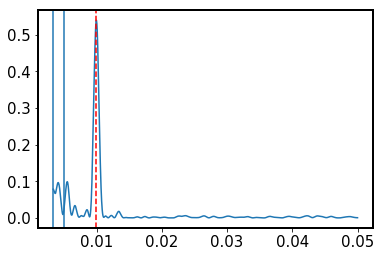

In [134]:
plt.plot(freqs, P_multi)
plt.axvline(f_peak, ls ='--', c='r')
print('Peak power is ', np.max(P_multi))
for m in [2,3]:
    plt.axvline(f_peak/m)
    p = np.interp(f_peak/m, freqs, P_multi)
    print('power at f_peak / ', m, '=', p)

"When using the Lomb-Scargle periodogram in an observational pipeline, it is vital to keep in mind the failure modes of the periodogram approach, which are rooted in the aliasing and pseudo-aliasing effects rooted in the structure of the window function" (Jake VdP, "Understanding Lomb Scargle Periodogram", pg. 37) 

"When applying a periodogram in practice, it is vital to take such effects into account, rather than blindly relying on the single periodogram peak as your best estimate of the period." ( Ibid, pg. 38) 



1) Check for a peak at fpeak/m for at least m ∈ {2,3}. If a significant peak is found, then fpeak
is probably an order-m harmonic of the true frequency

2) Check for peaks at |fpeak ±nδf| for at least n ∈ {1,2} (where δf is determined from plotting the survey window power, and is generally (1 day)−1 for ground-based surveys)

Plot the survey window power - i.e. the power spectrum of the observing window (see Practical Lomb scargle, Fig.13 https://github.com/jakevdp/PracticalLombScargle/blob/master/figures/LINEAR_binary.ipynb):

In [158]:
len(time)

5000

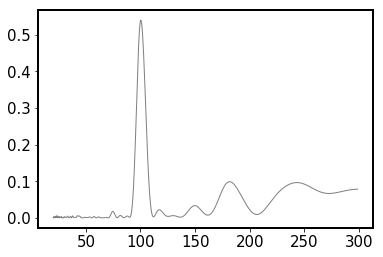

In [166]:
from gatspy.periodic import  LombScargle
ls_window = LombScargle(center_data = False)
ls_window.fit(t, 1 )
periods = np.logspace(np.log10(20),np.log10(0.3 * (max(time) - min(time))), 1000)
P_window = LS_multi.periodogram(periods)
plt.plot(periods, P_window , lw=1, color='gray')

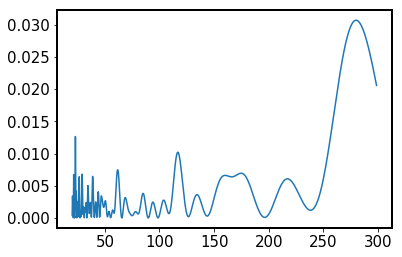

In [167]:
from astropy.stats import LombScargle
ls_window = LombScargle(t, 1 , fit_mean=False, center_data=False)

#freq, power = ls_window.autopower(minimum_frequency=1/max(periods), 
#                                  maximum_frequency=1/min(periods))
#plt.plot(1/freq, power)
power = ls_window.power(1/periods)
plt.plot(periods, power)



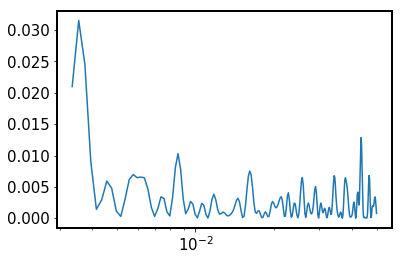

In [168]:
from astropy.stats import LombScargle
ls_window = LombScargle(t, 1, normalization='standard')
freq, power = ls_window.autopower(minimum_frequency=1/max(periods), 
                                  maximum_frequency=1/min(periods))
plt.semilogx(freq, power)

There is no noticeable $\delta f$ at 1 cycle/day here simply because these data consists of random draws from the uniform distribution between 1 and 1000. 

For real SDSS data the window function might look different: 



### Illustrate the effect of window function on RR Lyrae light curve 
(from https://github.com/astroML/gatspy/blob/master/examples/SingleBand.ipynb)

In [171]:
# Using RR Lyrae dataset from Sesar2010 , which 
# is given as an example one for gatspy 
# https://github.com/astroML/gatspy/blob/master/examples/SingleBand.ipynb


from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]
t, y, dy, filts = rrlyrae.get_lightcurve(lcid)

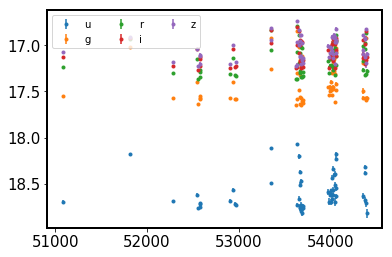

In [172]:
for filt in 'ugriz':
    mask = (filts == filt)
    plt.errorbar(t[mask], y[mask], dy[mask], fmt='.', label=filt)
plt.gca().invert_yaxis()
plt.legend(ncol=3, loc='upper left');

In [173]:
period = rrlyrae.get_metadata(lcid)['P']
period

0.61431831

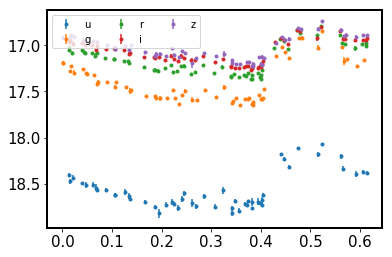

In [174]:
phase = t % period
for filt in 'ugriz':
    mask = (filts == filt)
    plt.errorbar(phase[mask], y[mask], dy[mask], fmt='.', label=filt)
plt.gca().invert_yaxis()
plt.legend(ncol=3, loc='upper left');

In [176]:
from gatspy.periodic import LombScargle, LombScargleFast
# LombScargleFast is slightly faster than LombScargle for the simplest case
# Both have the same interface.

model = LombScargleFast()
model.optimizer.set(quiet=True, period_range=(0.2, 1.2))

print("Sesar 2010:", period)
for filt in 'ugriz':
    mask = (filts == filt)
    model.fit(t[mask], y[mask], dy[mask])
    print(filt + ':         ', model.best_period)

Sesar 2010: 0.614318
u:          0.61431570304
g:          0.614316612117
r:          0.614316612117
i:          0.614317748467
z:          0.614316839386


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


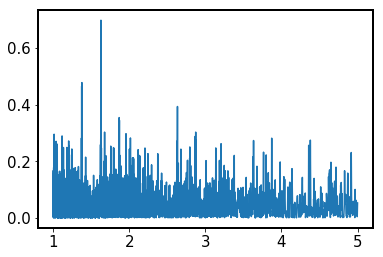

In [208]:
from gatspy.periodic import LombScargle, LombScargleFast
model = LombScargleFast()
model.optimizer.set(quiet=True, period_range=(0.2, 1.2))
model.fit(t[mask], y[mask], dy[mask])
#periods = np.logspace()
#period, power = model.periodogram_auto()
periods = np.logspace(np.log10(0.2), np.log10(1.2), 1000)
periods = np.linspace(0.2, 1.0, 5000)
power = model.periodogram(periods)
plt.plot(1/periods, power)

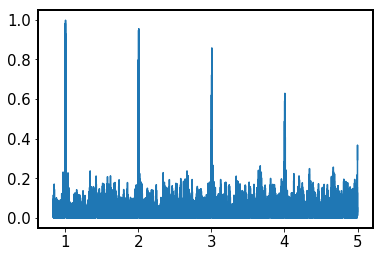

In [211]:
from astropy.stats import LombScargle
ls_window = LombScargle(t[mask], 1 , fit_mean=False, center_data=False)

freq, power = ls_window.autopower(minimum_frequency=1/1.2, 
                                  maximum_frequency=1/0.2)
#plt.plot(1/freq, power)
#power = ls_window.power(1/periods)
plt.plot(freq, power)



Here we see that there is a strong peak at $f_{window} = 1,2,3,4,5$ - exactly corresponding to a diurnal observing window present in SDSS data

Thus for the RR Lyrae dataset I'd have  to find :
* the peak frequency : $f_{peak}$
* the order-$m$ harmonic at $f_{peak} / m $ for $m \in \{ 2,3 \}$
* window function aliases at $|f_{peak} \pm n f_{alias}|$, with $n \in \{ 1,2\}$, and $f_{alias}$ determined from the LS of the survey observing times , but for ground-based surveys it's often  $f_{alias} = 1 / day $. 

power at f_peak /  2 = 0.03141663904493252
power at f_peak /  3 = 0.03141663904493252


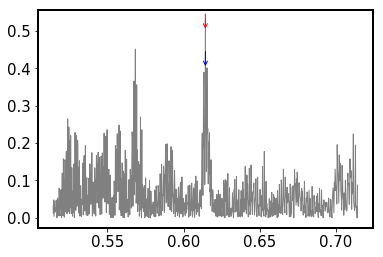

In [241]:
# initialize the model
Nbase  = 1; Nband = 0 
LS_multi = LombScargleMultiband(Nterms_base=Nbase, Nterms_band=Nband)


# grab the RR Lyr data from Sesar 
from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]
true_period = rrlyrae.get_metadata(lcid)['P']
time, mags, dy, filts = rrlyrae.get_lightcurve(lcid)

LS_multi.fit(time, mags, dy, filts)

# choose grid regular in frequency ...
frequencies = np.linspace(1/(true_period+0.1), 1/(true_period-0.1),  1000)
periods = 1 / frequencies

P_multi = LS_multi.periodogram(periods)

# mark the best period  : blue arrow 
best_period = periods[np.argmax(P_multi)]
f_peak = 1 / best_period

plt.annotate('', (best_period, 0.4), (best_period, 0.45),
                 arrowprops=dict(arrowstyle="->", color='blue', lw=1))

# mark the true period  : red arrow 
plt.annotate('', (true_period, 0.5), (true_period, 0.55),
                 arrowprops=dict(arrowstyle="->", color='red', lw=1))
    
# plot the periodogram 
plt.plot(periods, P_multi , lw=1, color='gray')

# check the harmonics ...
for m in [2,3]:
    p_harmonic = 1/( f_peak / m ) 
    #plt.axvline(p_harmonic)
    p = np.interp(p_harmonic, periods, P_multi)
    print('power at f_peak / ', m, '=', p)
    


The alias frequency is  1.00273824486  Hertz


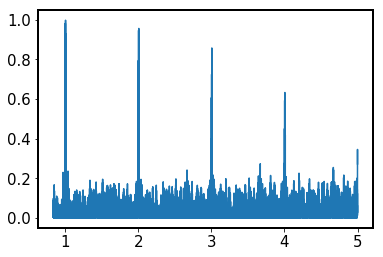

In [242]:
# check the aliases : 
# plot the window function  - just for one band 
ls_window = LombScargle(t, 1 , fit_mean=False, center_data=False)
freq, power = ls_window.autopower(minimum_frequency=1/1.2, 
                                  maximum_frequency=1/0.2)
plt.plot(freq, power)

f_alias = freq[np.argmax(power)]
print('The alias frequency is ', f_alias, ' Hertz')

We easily see that the appropriate $f_{alias} = 1 / \mathrm{day}$ here . 

f_alias= 0.03141663904493252  is beyond the grid
f_alias= 0.08770781304964055  is beyond the grid
f_alias= 0.08770781304964055  is beyond the grid
f_alias= 0.08770781304964055  is beyond the grid


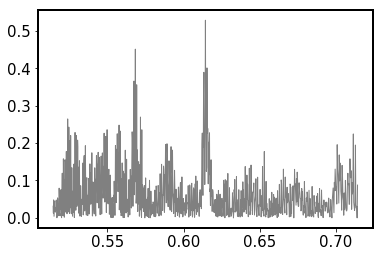

In [258]:
plt.plot(periods, P_multi , lw=1, color='gray')
for n in [1,2]:
    for pm in [-1,1] : 
        p_alias= 1/( f_peak  + pm * n * f_alias ) 
        p = np.interp(p_alias, periods, P_multi)
        if (p_alias > 0) and (p_alias < max(periods)) and ((p_alias > min(periods))) : 
            plt.axvline(p_alias)
            print('power at f_peak  '+str(np.sign(pm)), n, ' * f_alias =', p)
        else : 
            print('f_alias=', p, ' is beyond the grid')

        

### Illustrate multiband periodogram with DRW+sinusoid - Fig.5, Vanderplas+Ivezic2015

Use the simulated sin + DRW , illustrate how decreasing the number of obs per band enables better detection using the MultiBand LS ... ( equivalent of Fig.5 from Vanderplas+Ivezic, 2015 https://github.com/jakevdp/multiband_LS/blob/master/figures/fig05_multiband_sim.py)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# Use seaborn settings for plot styles
import seaborn; seaborn.set()
import sys
sys.path.append('/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code')
import modules as mod

%matplotlib inline

# DRW params 
tau_in = 100 # days 
# sigma_in = 0.2 # mag 
SF_inf = 0.2 # sigma_in * np.sqrt(2) 

# sinusoid params, 
# expressed in terms of DRW input timescale
# and the DRW asymptotic value of SF at large 
# dt 
#fP_values = [0.01,0.1,1,10,100]
#fA_values = [0.001,0.01,0.1,0.25,0.5,0.75,1] 

i =  0 
fP, fA = 1, 1 
#for fP, fA in product(fP_values, fA_values) : 
true_period =  fP * tau_in
omega = 2*np.pi / true_period
A  = fA * SF_inf

# the time space : ten times the input DRW timescale 
np.random.seed(41)  # The input coordinates must be sorted

N_per_band = 1000

t = np.sort(np.random.uniform(0, 10*tau_in, N_per_band ))  

# the photometric errors drawn from uniform distribution
# between lower and upper noise value 
yerr = np.random.uniform(0.01, 0.02, len(t))
noise = yerr * np.random.randn(len(t)) 

# simulate DRW with Gaussian noise 
y_DRW = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 0) 

print('True A=', A, ' true omega=', omega)

# add Gaussian noise to the pure sinusoid 
y_sin =  A*np.sin(omega*t) 

dic = {'time':t, 'sinusoid':y_sin, 'DRW':y_DRW, 
       'noise':noise, 
       'err':yerr,'tau':tau_in, 'SFinf':SF_inf,
       'fP':fP, 'fA':fA
      }
# we also save the time series here 
np.save('DRW_sin_time_series_'+str(i).zfill(2), dic)


# plot the combined time series on a separate panel 
y_g = y_sin+y_DRW+noise+17

# apply offsets ...
y_r = y_g - 0.245
y_u = y_g + 0.246
y_i = y_g - 0.459
y_z = y_g - 0.52 


# stack all times, errors, mags together,
# in a format digestible by gatspy LS Multiband 
t = np.tile(t,5)
dy = np.tile(yerr,5)
filts = np.tile(['u'], N_per_band )
for f in 'griz' : 
    filts = np.append(filts, np.tile([f], N_per_band))
    
mags = y_u
mags = np.append(mags, y_g)
mags = np.append(mags, y_r)
mags = np.append(mags, y_i)
mags = np.append(mags, y_z)

#----------------------------------------------------------------------
# First figure:
# Compute the lomb-scargle periodogram in each band

# choose grid regular in frequency ...
# this is because :
#
# " One final note: although it can be more easily interpretable to 
#  visualize periodograms as a function of period rather than a function 
#  of frequency, the peak widths are not constant in period. Regular grids 
#  in period rather than frequency tend to over-sample at large periods and 
#  under-sample at small periods; for this reason it is preferable to use 
#  a regular grid in frequency." ( pg. 36, Practical Lomb Scargle,JakeVdP 2017 )


from gatspy.periodic import (LombScargleAstroML, LombScargleMultiband,
                             NaiveMultiband)
pmin = 20 ; pmax = 0.3 * (max(t) - min(t))
fmin = 1 / pmax ; fmax  = 1/ pmin
frequencies = np.linspace(fmin, fmax, 1000)
periods = 1 / frequencies
print('Done')

True A= 0.2  true omega= 0.06283185307179587
Done


In [25]:
len(filts)

5000

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


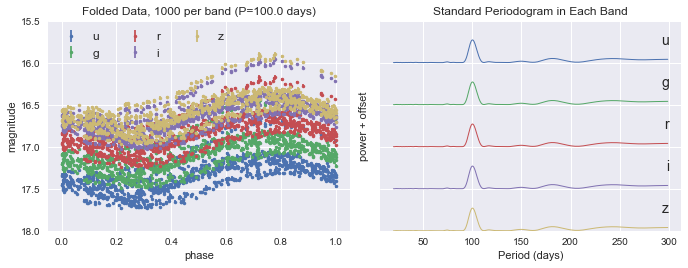

In [71]:
# First just use the single band LS ....
from gatspy.periodic import LombScargle, LombScargleFast
model = LombScargleFast()

# plot the data folded on true period ... 
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(left=0.07, right=0.95, wspace=0.1, bottom=0.15)

for i, band in enumerate('ugriz'):
    mask = filts == band
    ax[0].errorbar((t[mask] / true_period) % 1, mags[mask], dy[mask],
                   fmt='.', label=band)
ax[0].set_ylim(18, 15.5)
ax[0].legend(loc='upper left', fontsize=12, ncol=3)
ax[0].set_title('Folded Data, 1000 per band (P={0:.1f} days)'.format(true_period))
ax[0].set_xlabel('phase')
ax[0].set_ylabel('magnitude')

# plot the individual periodograms... 
for i, band in enumerate('ugriz'):
    offset = 4 - i
    mask = filts == band
    model.fit(t[mask], mags[mask], dy[mask])
    power = model.periodogram(periods)
    ax[1].plot(periods, power + offset, lw=1)
    ax[1].text(300, 0.7 + offset, band, fontsize=14, ha='right', va='top')
ax[1].set_title('Standard Periodogram in Each Band')
ax[1].set_ylim(0, 5)
ax[1].yaxis.set_major_formatter(plt.NullFormatter())
ax[1].set_xlabel('Period (days)')
ax[1].set_ylabel('power + offset')




Plot the initial light curve 




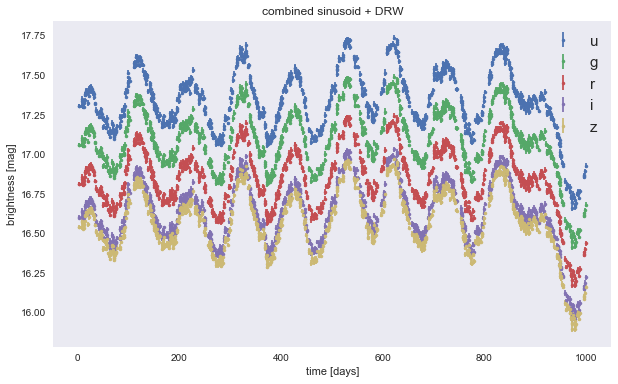

In [72]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i, band in enumerate('ugriz'):
    mask = filts == band
    ax.errorbar(t[mask], mags[mask], dy[mask], fmt=".",capsize=0, label=band)
ax.legend(fontsize=15)
ax.set_xlabel("time [days]")
ax.set_ylabel("brightness [mag]")
ax.set_title('combined sinusoid + DRW')
ax.grid()

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


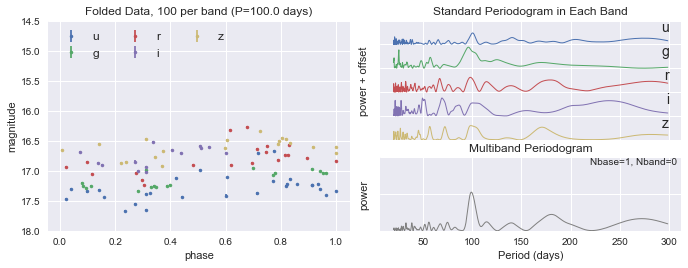

In [66]:
#----------------------------------------------------------------------
# Second figure:
# One observation per pass
    
# Alternate between the five bands. Because the times are randomized,
# the filter orders will also be randomized.

# select randomly only 1/5 of the initial points ... 
x  = np.arange(0, len(t))
random_indices= np.sort(np.random.choice(x, size=len(t) // 50, replace=False))
N_per_band = len(random_indices)

t_ = t[random_indices]
dy_ = dy[random_indices]
mags_ = mags[random_indices]
filts_ = filts[random_indices]


Nbase  = 1; Nband = 0 
model = LombScargleMultiband(Nterms_base=Nbase, Nterms_band=Nband)
model.fit(t_, mags_, dy_, filts_)
P = model.periodogram(periods)  # same period grid as above ... 
 
# plot the phased subsampled light curve 
fig = plt.figure(figsize=(10, 4))
gs = plt.GridSpec(5, 2, left=0.07, right=0.95, bottom=0.15,
                  wspace=0.1, hspace=0.6)
ax = [fig.add_subplot(gs[:, 0]),
      fig.add_subplot(gs[:-2, 1]),
      fig.add_subplot(gs[-2:, 1])]
    
for i, band in enumerate('ugriz'):
    mask = filts_ == band
    ax[0].errorbar((t_[mask] / true_period) % 1, mags_[mask], dy_[mask],
                   fmt='.', label=band)

ax[0].set_ylim(18, 14.5)
ax[0].legend(loc='upper left', fontsize=12, ncol=3)
ax[0].set_title('Folded Data, {0:d} per band (P={1:.1f} days)'.format(N_per_band, 
                                                                       true_period))
ax[0].set_xlabel('phase')
ax[0].set_ylabel('magnitude')



# calculate standard periodogram in each band 
model = LombScargleFast()
for i, band in enumerate('ugriz'):
    offset = 4 - i
    mask = filts_ == band
    model.fit(t_[mask], mags_[mask], dy_[mask])
    power = model.periodogram(periods)
    ax[1].plot(periods, power + offset, lw=1)
    ax[1].text(300, 1 + offset, band, fontsize=14, ha='right', va='top')
ax[1].set_title('Standard Periodogram in Each Band')
ax[1].set_ylim(0, 5)
ax[1].set_ylabel('power + offset')
ax[1].yaxis.set_major_formatter(plt.NullFormatter())
ax[1].xaxis.set_major_formatter(plt.NullFormatter())

# calculate multiband periodogram using all data 

i, Nbase, Nband = (0, 1, 0)
LS_multi = LombScargleMultiband(Nterms_base=Nbase, Nterms_band=Nband)
LS_multi.fit(t_, mags_, dy_, filts_)
P_multi = LS_multi.periodogram(periods)
ax[2].plot(periods, P_multi + i, lw=1, color='gray')
ax[2].text(220, 1.0 + i,
           "Nbase={0}, Nband={1}".format(Nbase, Nband),
           fontsize=10, ha='left', va='top')

ax[2].set_title('Multiband Periodogram')
ax[2].set_yticks([0, 0.5, 1.0])
ax[2].set_ylim(0, 1.0)
ax[2].yaxis.set_major_formatter(plt.NullFormatter())
ax[2].set_xlabel('Period (days)')
ax[2].set_ylabel('power')



Show what the downgraded light curve looks like...


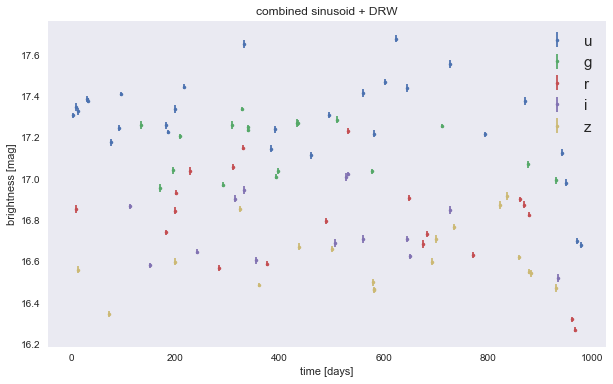

In [73]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i, band in enumerate('ugriz'):
    mask = filts_ == band
    ax.errorbar(t_[mask], mags_[mask], dy_[mask], fmt=".",capsize=0, label=band)
ax.legend(fontsize=15)
ax.set_xlabel("time [days]")
ax.set_ylabel("brightness [mag]")
ax.set_title('combined sinusoid + DRW')
ax.grid()

Instructions for AstroPy LombScargle http://docs.astropy.org/en/stable/stats/lombscargle.html 